## Reranking an existing model

Can we improve on the existing LR model?

Ideally we'd first now how it's poor, then impose constraints to correct for that.

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import maxentropy
import maxentropy.utils as utils

import plotly.io as pio
pio.renderers.default = 'plotly_mimetype'

import plotly.express as px

from sklearn.datasets import load_iris, load_breast_cancer

iris = load_iris()
cancer = load_breast_cancer(as_frame=True)

In [2]:
import toolz as tz

## First example: find the model with minimum relative entropy to some prior model subject to a non-negativity constraint

In [157]:
# print(cancer['DESCR'])

In [3]:
cancer['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [4]:
df_cancer = cancer['data']
X_cancer = cancer['data'].values
y_cancer = cancer['target']

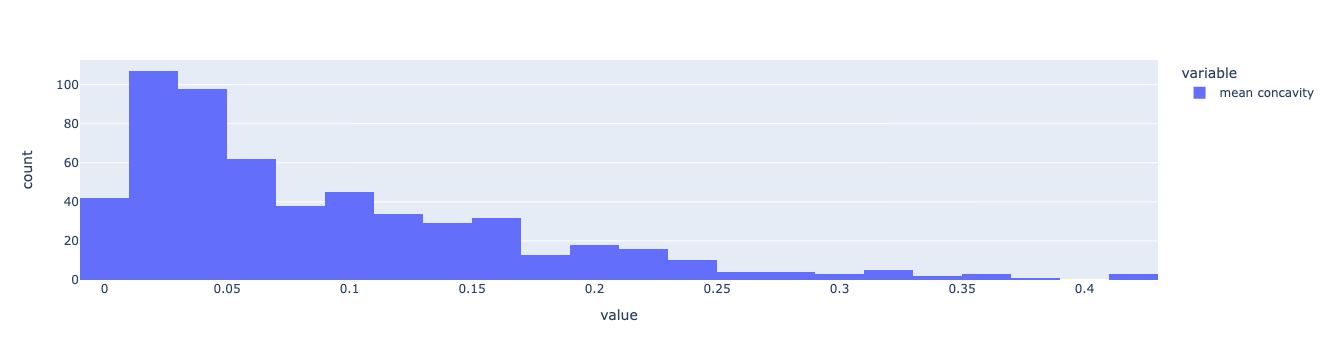

In [5]:
px.histogram(df_cancer['mean concavity'])

## Try fitting a simple classifier in this 1 dimension

In [6]:
X_subset = df_cancer[['mean concavity']].values

In [7]:
model_lr = LogisticRegression(max_iter=5_000)
model_lr.fit(X_subset, y_cancer)
model_lr.score(X_subset, y_cancer)

0.7926186291739895

In [8]:
X_subset.shape

(569, 1)

In [9]:
np.bincount(y_cancer) / np.sum(np.bincount(y_cancer))

array([0.37258348, 0.62741652])

In [10]:
df_cancer['target'] = cancer['target_names'][y_cancer]

In [11]:
# px.histogram(df_cancer, x='mean concavity', color='target')

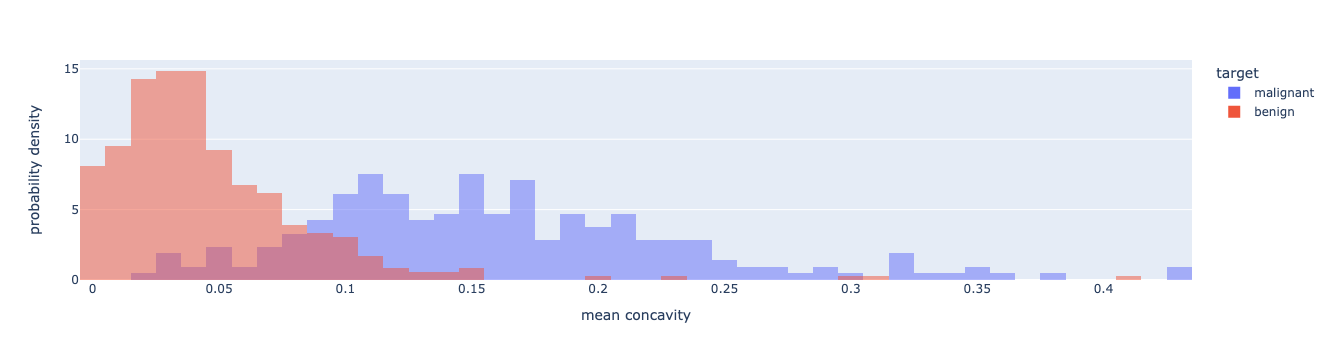

In [12]:
fig_hists = px.histogram(df_cancer, x='mean concavity', color='target', histnorm='probability density', barmode='overlay', nbins=80)
fig_hists

In [13]:
model_lr.predict([[0.05], [0.1], [0.15], [0.17], [0.2]])

array([1, 1, 1, 0, 0])

#### Idea: the classifier induces a probability density `p(x | k)` based on its outputs of `p(k | x)`. Plot this.

In [14]:
xs = np.linspace(-0.5, 0.5, num=1001)
X = np.reshape(xs, (-1, 1))
pred = model_lr.predict_proba(X)

In [15]:
pred_df = pd.DataFrame(pred, columns=cancer['target_names'])

In [16]:
pred_df['mean concavity'] = xs

In [17]:
pred_df[:3]

,malignant,benign,mean concavity
0,0.003928,0.996072,-0.500
1,0.003961,0.996039,-0.499
2,0.003995,0.996005,-0.498


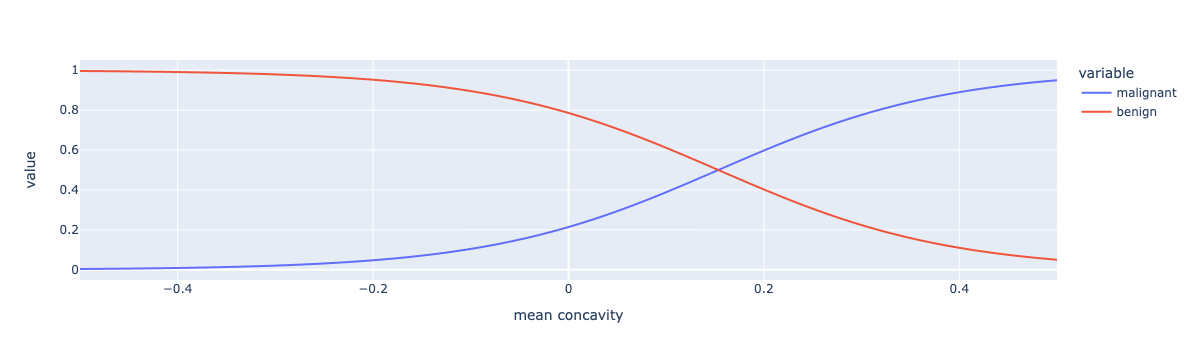

In [18]:
fig_logistic = px.line(pred_df, x='mean concavity', y=['malignant', 'benign'])
fig_logistic

In [19]:
len(fig_hists.data)

2

In [159]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=4, cols=1,  shared_xaxes=True, height=800)
fig.add_traces(fig_hists.data, rows=1, cols=1)
fig.add_traces(fig_logistic.data, rows=2, cols=1)

TypeError: make_subplots() got unexpected keyword argument(s): ['height']

In [21]:
@tz.curry
def non_neg(column, X):
    return X[:, column] >= 0

In [22]:
@tz.curry
def cutoff(cutoff, column, X):
    """
    Adding this as a constraint forces our component class densities to have 0 probability above this cutoff.
    """
    return X[:, column] <= cutoff

In [23]:
@tz.curry
def identity(column, X):
    """
    Constrains the mean of the given column:
        E(X) = k
    """
    return X[:, column]

In [24]:
@tz.curry
def quantile(quantile, column, X):
    """
    Constrains a quantile, like this:

    E(quantile(0.99)) = k

    sets the expected x value that causes the cumulative density function (CDF) to be 99%.

    i.e. constrains the inverse CDF of 0.99.
    """
    return np.quantile(X[:, column], quantile)

In [25]:
@tz.curry
def square(column, X):
    return X[:, column]**2

In [26]:
np.quantile(X_subset[:, 0], 0.99)

0.35168800000000006

In [95]:
feature_functions = [
    non_neg(i) for i in range(X_subset.shape[1])   # the malignant class doesn't fit well without an upper bound too
] + [
    cutoff(0.5, i) for i in range(X_subset.shape[1])
]

# feature_functions = [
#     non_neg(i) for i in range(X_subset.shape[1])   # the malignant class doesn't fit well without an upper bound too
# ] + [
#     identity(i) for i in range(X_subset.shape[1])
# ] + [
#     square(i) for i in range(X_subset.shape[1])
# ]

In [96]:
y_freq = np.bincount(y_cancer)
y_freq = y_freq / np.sum(y_freq)
y_freq

array([0.37258348, 0.62741652])

In [97]:
# stretched_minima, stretched_maxima = utils.bounds_stretched(X_subset, 100.0)
stretched_minima, stretched_maxima = (-.5, .6)
uniform_dist = scipy.stats.uniform(
    stretched_minima, stretched_maxima - stretched_minima
)
sampler = utils.auxiliary_sampler_scipy(
    uniform_dist, n_dims=X_subset.shape[1], n_samples=100_000
)

In [98]:
next(sampler)[0]

array([[0.42409847],
       [0.30729294],
       [0.58985719],
       ...,
       [0.06082318],
       [0.10893177],
       [0.57065635]])

In [99]:
clf = maxentropy.MinKLClassifier(
    feature_functions,
    sampler,
    prior_clf=model_lr,
    prior_class_probs=y_freq,
    matrix_format='ndarray',
    vectorized=True
)
clf.fit(X_subset, y_cancer)
clf.score(X_subset, y_cancer)

0.648506151142355

In [100]:
clf.models[0].params

array([16.93564357, 18.17437412])

In [101]:
clf.models[1].params

array([20.35007743, 15.43603299])

In [102]:
X_subset[:5]

array([[0.3001],
       [0.0869],
       [0.1974],
       [0.2414],
       [0.198 ]])

In [103]:
clf.models[0].predict_log_proba(X_subset)[:5]

array([0.87674323, 0.11638308, 0.60630233, 0.74200223, 0.60837214])

In [104]:
clf.models[1].predict_log_proba(X_subset)[:5]

array([0.2404578 , 1.28648038, 0.84016468, 0.60306514, 0.83715086])

In [105]:
clf.models[0].features(X_subset)[:5]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [106]:
log_scores = np.array(
            [model.predict_log_proba(X_subset) for model in clf.models.values()]
        ).T

In [107]:
np.exp(log_scores)

array([[2.40306073, 1.27183126],
       [1.12342615, 3.62002299],
       [1.83363866, 2.31674847],
       ...,
       [1.15766598, 3.55719124],
       [2.60893131, 0.89404872],
       [0.66344666, 4.46410775]])

In [108]:
len(X_subset)

569

In [109]:
df_components = pd.DataFrame(np.exp(log_scores), columns=['malignant density', 'benign density'])
df_components['mean concavity'] = X_subset[:, 0]

In [110]:
df_components[:2]

,malignant density,benign density,mean concavity
0,2.403061,1.271831,0.3001
1,1.123426,3.620023,0.0869


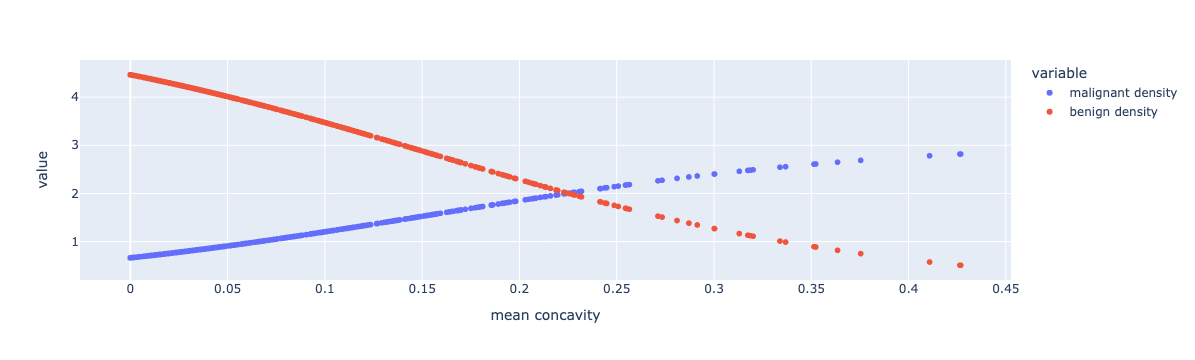

In [111]:
fig_fitted_densities = px.scatter(df_components, x='mean concavity', y=['malignant density', 'benign density'])
fig_fitted_densities

In [158]:
fig.add_traces(fig_fitted_densities.data, rows=3, cols=1)

TypeError: Figure.add_traces() got an unexpected keyword argument 'height'

In [113]:
xs = np.linspace(-.5, .6, num=10001)
X = np.reshape(xs, (-1, 1))
pred0 = clf.models[0].predict_proba(X)
pred1 = clf.models[1].predict_proba(X)

In [114]:
clf_pred_df = pd.DataFrame({'malignant': pred0, 'benign': pred1, 'mean concavity': xs})

In [115]:
clf_pred_df.describe()

,malignant,benign,mean concavity
count,1.000100e+04,1.000100e+04,10001.00000
mean,9.125360e-01,9.074650e-01,0.05000
std,1.111971e+00,1.336367e+00,0.31759
min,5.369661e-10,6.484071e-09,-0.50000
25%,5.324826e-09,8.038458e-09,-0.22500
50%,3.827935e-08,3.768107e-08,0.05000
75%,2.003435e+00,1.493408e+00,0.32500
max,2.940116e+00,4.463621e+00,0.60000


In [116]:
clf_pred_df[np.isinf(clf_pred_df['benign'])]

,malignant,benign,mean concavity


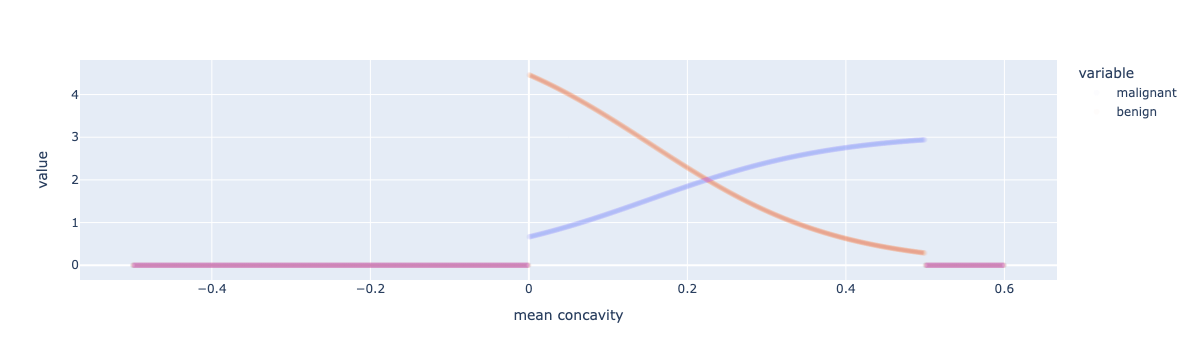

In [117]:
px.scatter(clf_pred_df, x='mean concavity', y=['malignant', 'benign']).update_traces(opacity=.01)

### Also constrain the mean

In [118]:
feature_functions = [
    non_neg(i) for i in range(X_subset.shape[1])   # the malignant class doesn't fit well without an upper bound too
] + [
    cutoff(0.5, i) for i in range(X_subset.shape[1])
] + [
    identity(i) for i in range(X_subset.shape[1])
]

In [120]:
clf = maxentropy.MinKLClassifier(
    feature_functions,
    sampler,
    prior_clf=model_lr,
    prior_class_probs=y_freq,
    matrix_format='ndarray',
    vectorized=True
)
clf.fit(X_subset, y_cancer)
clf.score(X_subset, y_cancer)

0.8699472759226714

In [121]:
log_scores = np.array(
            [model.predict_log_proba(X_subset) for model in clf.models.values()]
        ).T

In [122]:
np.exp(log_scores)

array([[1.34915455e+00, 2.19686781e-02],
       [3.50602446e+00, 3.40581312e+00],
       [2.35217635e+00, 2.74512594e-01],
       ...,
       [3.45343238e+00, 3.01254277e+00],
       [9.69403828e-01, 5.90185179e-03],
       [4.16606927e+00, 2.14234888e+01]])

In [123]:
len(X_subset)

569

In [124]:
df_components = pd.DataFrame(np.exp(log_scores), columns=['malignant density', 'benign density'])
df_components['mean concavity'] = X_subset[:, 0]

In [125]:
df_components[:2]

,malignant density,benign density,mean concavity
0,1.349155,0.021969,0.3001
1,3.506024,3.405813,0.0869


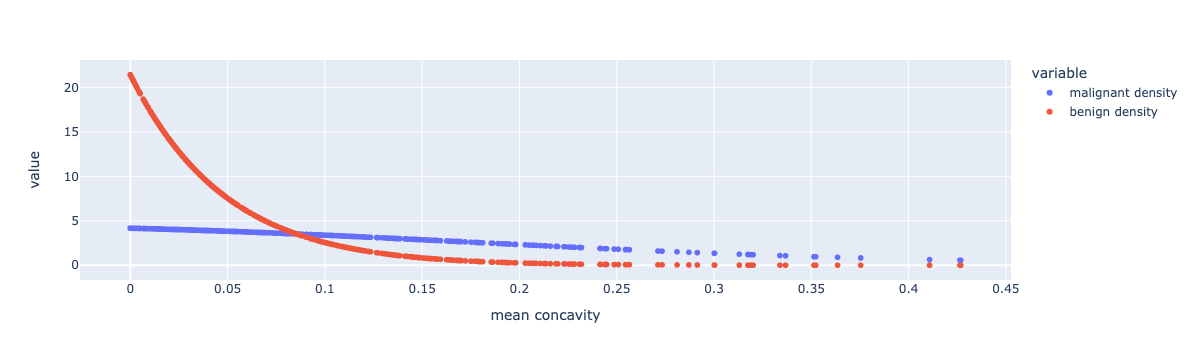

In [126]:
fig_fitted_densities = px.scatter(df_components, x='mean concavity', y=['malignant density', 'benign density'])
fig_fitted_densities

In [127]:
log_scores = np.array(
            [model.predict_log_proba(X_subset) for model in clf.models.values()]
        ).T

In [128]:
np.exp(log_scores)

array([[1.34915455e+00, 2.19686781e-02],
       [3.50602446e+00, 3.40581312e+00],
       [2.35217635e+00, 2.74512594e-01],
       ...,
       [3.45343238e+00, 3.01254277e+00],
       [9.69403828e-01, 5.90185179e-03],
       [4.16606927e+00, 2.14234888e+01]])

In [129]:
len(X_subset)

569

In [130]:
df_components = pd.DataFrame(np.exp(log_scores), columns=['malignant density', 'benign density'])
df_components['mean concavity'] = X_subset[:, 0]

In [131]:
df_components[:2]

,malignant density,benign density,mean concavity
0,1.349155,0.021969,0.3001
1,3.506024,3.405813,0.0869


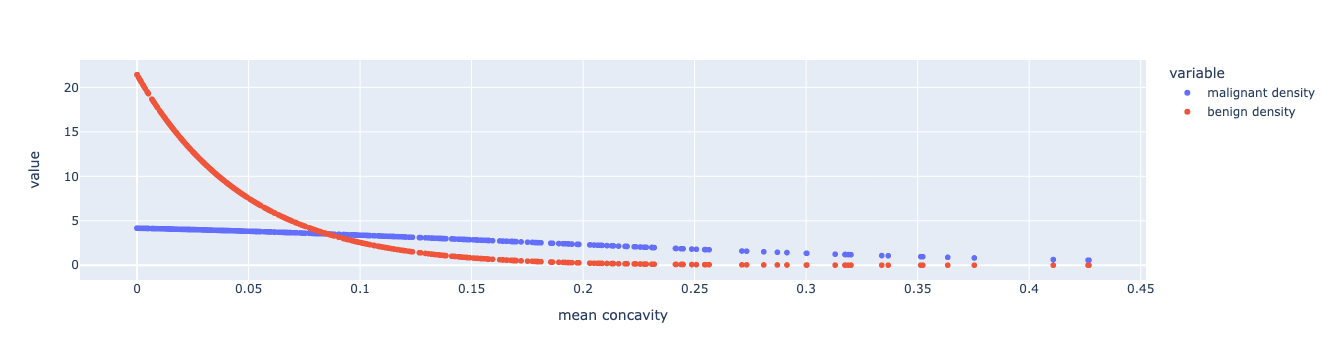

In [132]:
fig_fitted_densities2 = px.scatter(df_components, x='mean concavity', y=['malignant density', 'benign density'])
fig_fitted_densities2

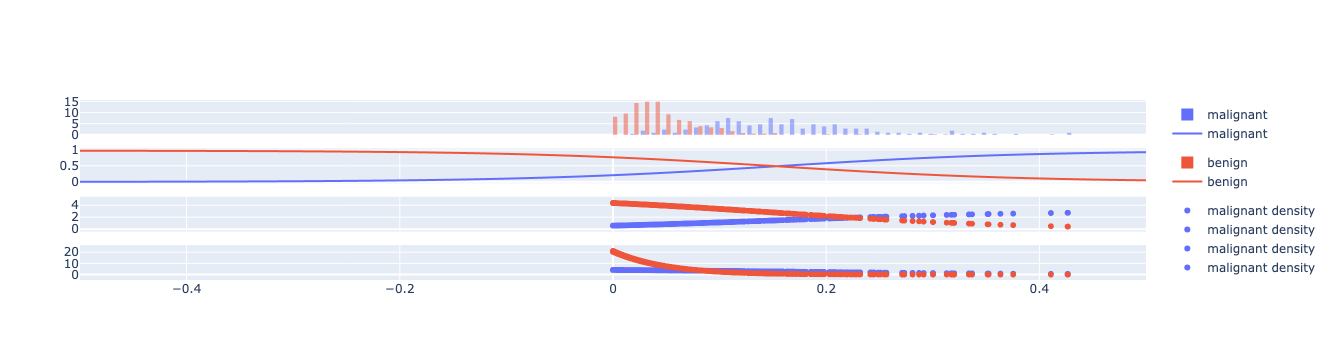

In [133]:
fig.add_traces(fig_fitted_densities2.data, rows=4, cols=1)

### Now add the square as well

In [134]:
feature_functions = [
    non_neg(i) for i in range(X_subset.shape[1])   # the malignant class doesn't fit well without an upper bound too
] + [
    cutoff(0.5, i) for i in range(X_subset.shape[1])
] + [
    identity(i) for i in range(X_subset.shape[1])
] + [
    square(i) for i in range(X_subset.shape[1])
]

In [137]:
clf = maxentropy.MinKLClassifier(
    feature_functions,
    sampler,
    prior_clf=model_lr,
    prior_class_probs=y_freq,
    matrix_format='ndarray',
    vectorized=True
)
clf.fit(X_subset, y_cancer)
clf.score(X_subset, y_cancer)

0.8840070298769771

In [138]:
log_scores = np.array(
            [model.predict_log_proba(X_subset) for model in clf.models.values()]
        ).T

In [139]:
df_components = pd.DataFrame(np.exp(log_scores), columns=['malignant density', 'benign density'])
df_components['mean concavity'] = X_subset[:, 0]

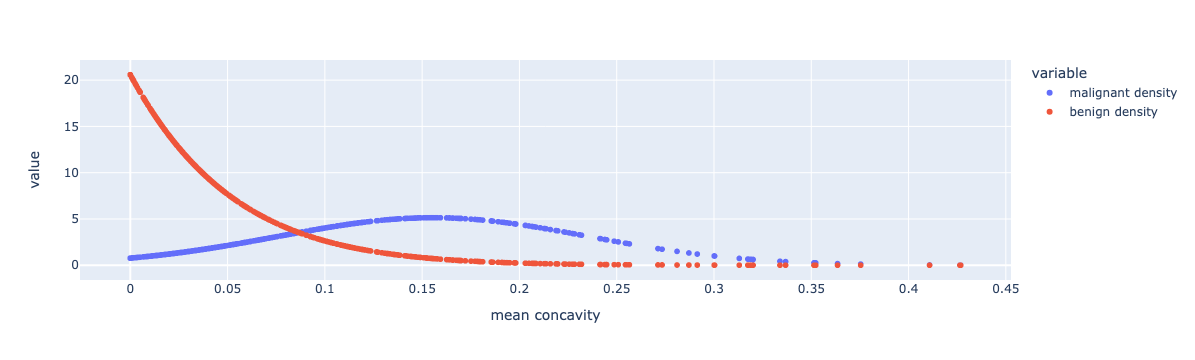

In [140]:
fig_fitted_densities3 = px.scatter(df_components, x='mean concavity', y=['malignant density', 'benign density'])
fig_fitted_densities3

In [141]:
np.exp(log_scores)

array([[1.00164824e+00, 1.50719257e-02],
       [3.54006666e+00, 3.50963392e+00],
       [4.47617731e+00, 2.53879888e-01],
       ...,
       [3.75216445e+00, 3.10385679e+00],
       [2.58923471e-01, 3.24728702e-03],
       [7.70532962e-01, 2.05808896e+01]])

In [142]:
log_scores.T.shape

(2, 569)

In [143]:
from scipy.special import logsumexp

In [144]:
log_scores = np.array(
            [model.predict_log_proba(X) for model in clf.models.values()]
        ).T
log_scores.shape

(10001, 2)

In [145]:
log_proba = log_scores + np.log(clf.prior_class_probs)

In [146]:
log_proba.shape

(10001, 2)

In [147]:
log_proba = (log_proba.T - logsumexp(log_proba, axis=1)).T

In [148]:
log_proba.shape

(10001, 2)

In [149]:
pred = clf.predict_proba(X_subset)
pred

array([[0.9752874 , 0.0247126 ],
       [0.37460398, 0.62539602],
       [0.91281603, 0.08718397],
       ...,
       [0.41788491, 0.58211509],
       [0.9793174 , 0.0206826 ],
       [0.02174928, 0.97825072]])

In [150]:
y_freq

array([0.37258348, 0.62741652])

In [151]:
df_clf_proba = pd.DataFrame({'mean concavity': X_subset[:, 0], 'prob malignant': pred[:, 0], 'prob benign': pred[:, 1]})

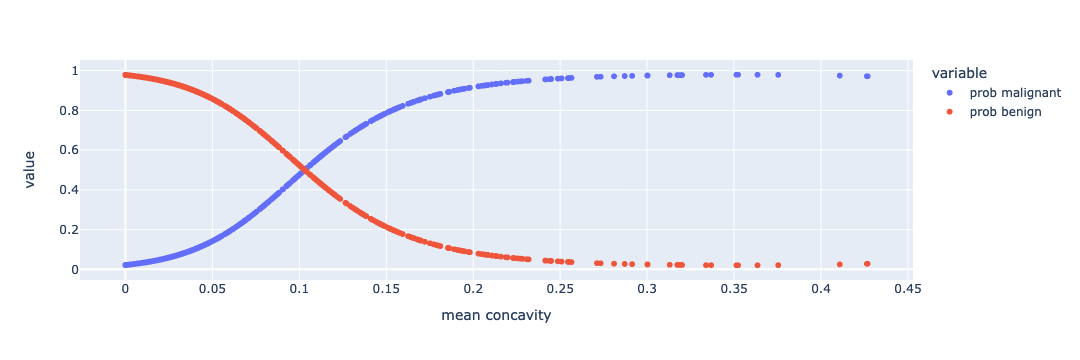

In [152]:
fig_clf_proba = px.scatter(df_clf_proba, x='mean concavity', y=['prob malignant', 'prob benign'])
fig_clf_proba

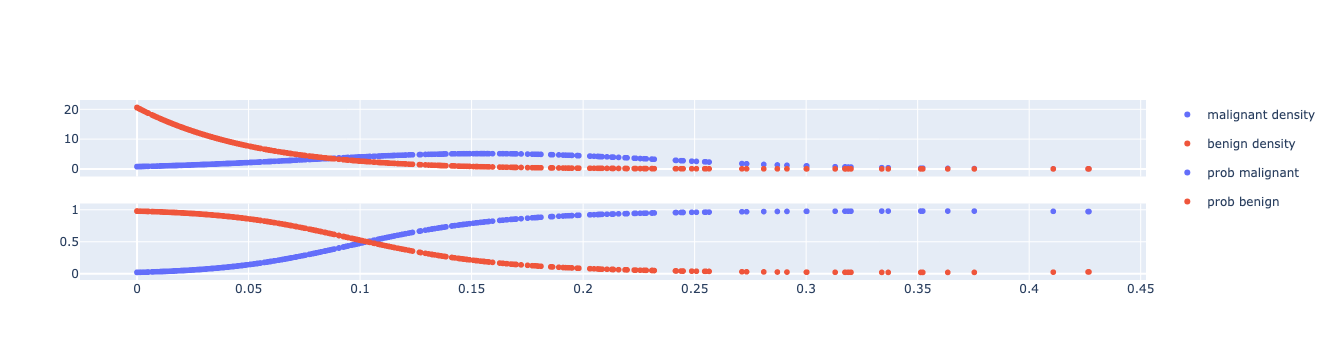

In [153]:
fig_final = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig_final.add_traces(fig_fitted_densities3.data, rows=1, cols=1)
fig_final.add_traces(fig_clf_proba.data, rows=2, cols=1)

In [154]:
from sklearn.metrics import accuracy_score

In [155]:
y_pred = clf.predict(X_subset)
accuracy_score(y_cancer, y_pred)

0.8840070298769771

In [ ]:
%debug

In [ ]:
clf.score(X_subset, y_cancer)

In [ ]:
%debug

In [ ]:
BREAK

## 

##### Desired API

In [ ]:
model = maxentropy.SamplingMinKLDensity(sampler='uniform', matrix_format='ndarray', sampling_stretch_factor=0.1, n_samples=10_000)

In [ ]:
feature_functions = [non_neg] * X_cancer.shape[1]

model.fit(X_cancer, feature_functions=feature_functions)

In [ ]:
def non_neg(x):
    return x >= 0